In [38]:
import pandas as pd
import numpy as np

from pathlib import Path
from fastai.conv_learner import *

PATH = Path('/data/airbus/')
list(PATH.iterdir())

[PosixPath('/data/airbus/sample_submission.csv'),
 PosixPath('/data/airbus/tmp'),
 PosixPath('/data/airbus/train_ship_segmentations.csv'),
 PosixPath('/data/airbus/train'),
 PosixPath('/data/airbus/models'),
 PosixPath('/data/airbus/test'),
 PosixPath('/data/airbus/train-128'),
 PosixPath('/data/airbus/train_masks'),
 PosixPath('/data/airbus/train_masks-128')]

In [39]:
segments = pd.read_csv(PATH/'train_ship_segmentations.csv')
segments.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


In [40]:
counts = segments.groupby('ImageId')['EncodedPixels'].count().sort_values(ascending = False)
counts.head()

ImageId
dbfd1d7cc.jpg    15
4ea5a8a2f.jpg    15
405b98f45.jpg    15
73361816c.jpg    15
731d25545.jpg    15
Name: EncodedPixels, dtype: int64

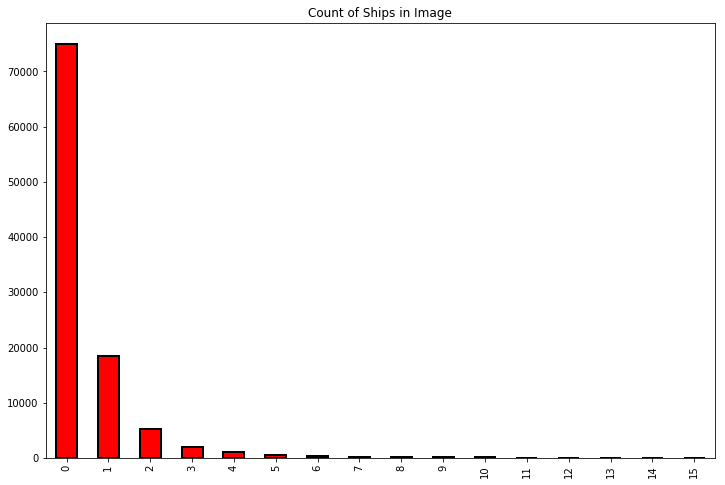

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12, 8))
counts.value_counts().plot.bar(color = 'r', edgecolor = 'k', linewidth = 2);
plt.title('Count of Ships in Image');

In [42]:
encoded = np.array(segments.loc[1, 'EncodedPixels'].split(), int)
encoded[:10]

array([264661,     17, 265429,     33, 266197,     33, 266965,     33, 267733,     33])

In [43]:
np.sum(encoded[1::2])

3388

In [44]:
def count_pixels(x):
    if pd.isna(x):
        return x
    else:
        return np.sum(np.array(x.split(), int)[1::2])
    
totals = segments['EncodedPixels'].apply(count_pixels)
segments['total_pixels'] = list(totals)
segments.describe()

,total_pixels
count,56030.000000
mean,1565.500553
std,2851.370259
min,2.000000
25%,111.000000
50%,403.000000
75%,1541.000000
max,25904.000000


In [45]:
segments[segments['total_pixels'] == 2]

,ImageId,EncodedPixels,total_pixels
1311,02776139a.jpg,33570 2,2.0
35856,461f9e3e6.jpg,199006 1 200541 1,2.0
44212,5676dac91.jpg,199518 1 201053 1,2.0
49557,60ca4f877.jpg,230178 2,2.0
57031,6f4bac38d.jpg,396126 1 397661 1,2.0
62183,79123fc78.jpg,426530 2,2.0
65236,7efdb69ff.jpg,395614 1 397149 1,2.0
79081,9a39363b0.jpg,229922 2,2.0
91289,b22e2f206.jpg,199262 1 200797 1,2.0
113084,dd38da47f.jpg,33314 2,2.0


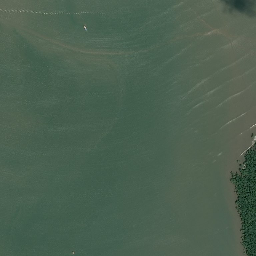

In [50]:
Image.open(PATH/'train/461f9e3e6.jpg').resize((256, 256))

In [54]:
segments.loc[segments['total_pixels'] > 25000]

,ImageId,EncodedPixels,total_pixels
64287,7d35cf46b.jpg,180785 3 181547 9 182309 15 183071 21 183833 2...,25245.0
82598,a129c36b3.jpg,135723 4 136484 11 137244 19 138005 26 138766 ...,25904.0
107888,d30187b5a.jpg,181041 3 181803 9 182565 15 183327 21 184089 2...,25245.0
120555,eba27cc8a.jpg,135467 4 136228 11 136988 19 137749 26 138510 ...,25904.0


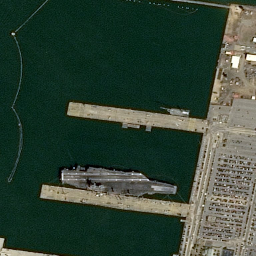

In [55]:
Image.open(PATH/'train/a129c36b3.jpg').resize((256, 256))

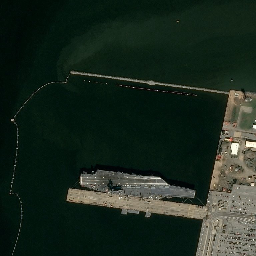

In [56]:
Image.open(PATH/'train/d30187b5a.jpg').resize((256, 256))

In [59]:
images = pd.DataFrame(counts).rename(columns = {'EncodedPixels': 'ships'})
images['total'] = segments.groupby('ImageId')['total_pixels'].sum()
images['pixels_per_ship'] = images['total'] / images['ships']
images.head()

,ships,total,pixels_per_ship
ImageId,,,
dbfd1d7cc.jpg,15,1610.0,107.333333
4ea5a8a2f.jpg,15,988.0,65.866667
405b98f45.jpg,15,898.0,59.866667
73361816c.jpg,15,1099.0,73.266667
731d25545.jpg,15,988.0,65.866667


In [60]:
images[images['total'] > 50000]

,ships,total,pixels_per_ship
ImageId,,,
0334e61a7.jpg,12,50745.0,4228.750000
ccfb18b6c.jpg,8,76720.0,9590.000000
eeafd580e.jpg,7,56813.0,8116.142857
a182903f8.jpg,7,56813.0,8116.142857


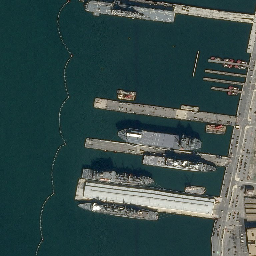

In [63]:
Image.open(PATH/'train/0334e61a7.jpg').resize((256, 256))

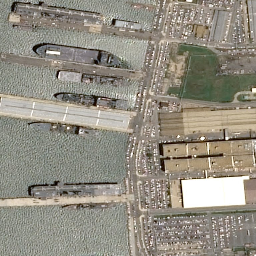

In [62]:
Image.open(PATH/'train/eeafd580e.jpg').resize((256, 256))

In [68]:
images['ships'] = images['ships'].fillna(0)

(array([75000., 18525.,  5232.,  2032.,  1079.,   609.,   453.,   273.,   223.,   173.,   121.,    99.,
           93.,    59.,    99.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.]),
 <a list of 15 Patch objects>)

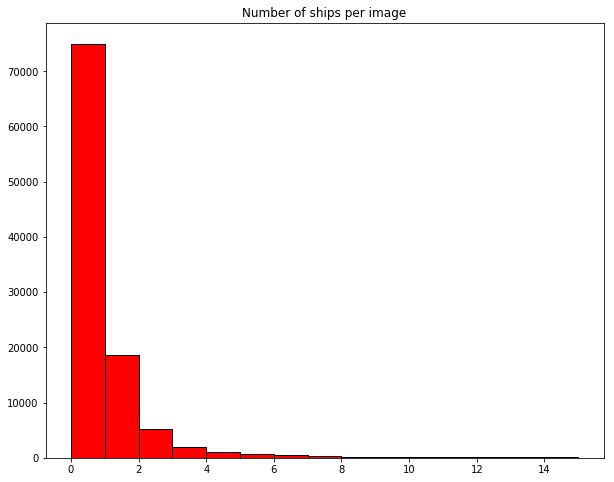

In [76]:
plt.figure(figsize = (10, 8))
plt.title('Number of ships per image');
plt.hist(images['ships'], color = 'r', edgecolor = 'k', bins = 15)

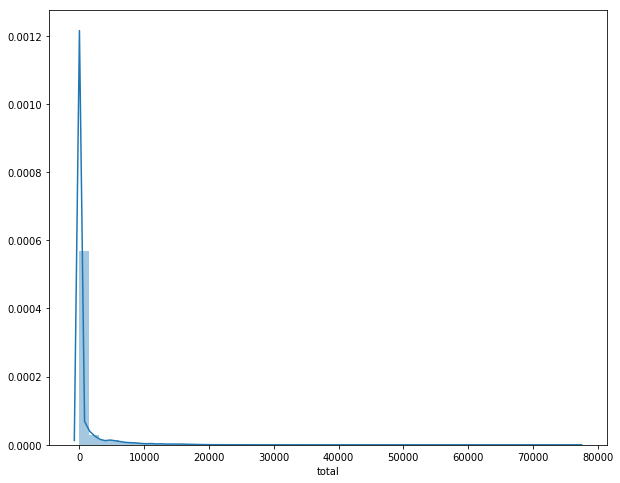

In [81]:
plt.figure(figsize = (10, 8))
sns.distplot(images['total']);

In [105]:
from sklearn.model_selection import train_test_split

X_train, X_test, ships_train, ships_test = train_test_split(images, images['ships'], stratify = images['ships'],
                                                            test_size = 10000)

In [106]:
len(X_train), len(X_test)

(94070, 10000)

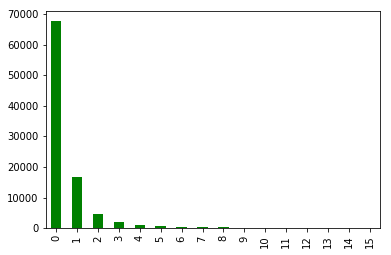

In [107]:
ships_train.value_counts().plot.bar(color = 'g')

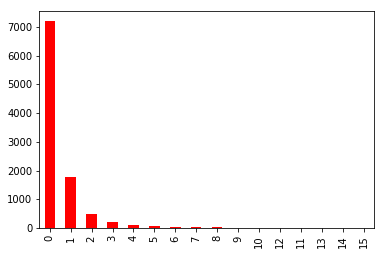

In [108]:
ships_test.value_counts().plot.bar(color = 'r')

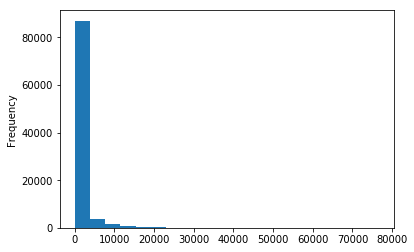

In [109]:
X_train['total'].plot.hist(bins = 20);

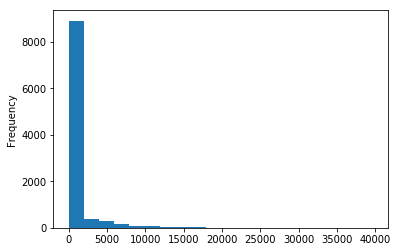

In [110]:
X_test['total'].plot.hist(bins = 20);

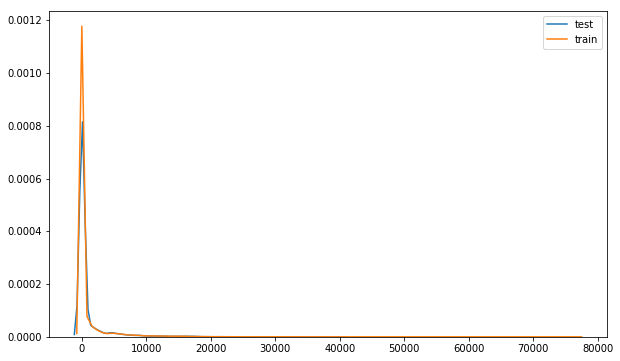

In [112]:
plt.figure(figsize = (10, 6))
sns.kdeplot(X_test['total'], label = 'test')
sns.kdeplot(X_train['total'], label = 'train')
plt.legend();

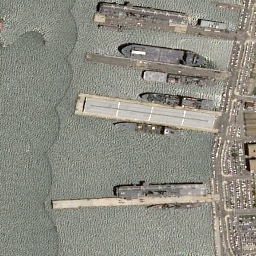

In [113]:
Image.open(PATH/'train/a182903f8.jpg').resize((256, 256))

In [116]:
images.sort_values('pixels_per_ship', ascending = False).head()

,ships,total,pixels_per_ship
ImageId,,,
eba27cc8a.jpg,1,25904.0,25904.0
a129c36b3.jpg,1,25904.0,25904.0
d30187b5a.jpg,1,25245.0,25245.0
e33e51b8e.jpg,1,24216.0,24216.0
0dd92e511.jpg,1,24216.0,24216.0


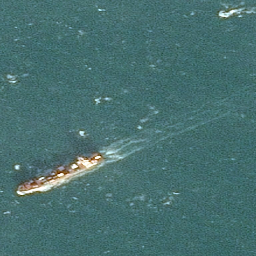

In [120]:
Image.open(PATH/'train/e33e51b8e.jpg').resize((256, 256))

In [121]:
images['ships'].nunique()

16

# Run Length Encoding to Mask

In [126]:
def rle_decode(encoded, height = 768, width = 768):
    m_f = np.zeros(height * width, dtype = np.uint8)
    pixels = encoded[::2] - 1
    num = encoded[1::2]

    # Iterate through the pixels
    for start, n_p in zip(pixels, num):
        m_f[start: start + n_p] = 255

    return m_f.reshape((height, width), order = 'F')

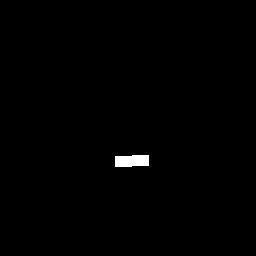

In [127]:
mask = rle_decode(encoded)
Image.fromarray(mask).resize((256, 256))

# Mask to Run Length Encoding

In [ ]:
def rle_decode(mask):
    

In [4]:
encoded[::2]

array([264661, 265429, 266197, 266965, 267733, 268501, 269269, 270037,
       270805, 271573, 272341, 273109, 273877, 274645, 275413, 276181,
       276949, 277716, 278484, 279252, 280020, 280788, 281556, 282324,
       283092, 283860, 284628, 285396, 286164, 286932, 287700, 288468,
       289236, 290004, 290772, 291540, 292308, 293076, 293844, 294612,
       295380, 296148, 296916, 297684, 298452, 299220, 299988, 300756,
       301524, 302292, 303060, 303827, 304595, 305363, 306131, 306899,
       307667, 308435, 309203, 309971, 310739, 311507, 312275, 313043,
       313811, 314579, 315347, 316115, 316883, 317651, 318419, 319187,
       319955, 320723, 321491, 322259, 323027, 323795, 324563, 325331,
       326099, 326867, 327635, 328403, 329171, 329938, 330706, 331474,
       332242, 333010, 333778, 334546, 335314, 336082, 336850, 337618,
       338386, 339154, 339922, 340690, 341458, 342226, 343003, 343787])